In [71]:
# import numpy library for math operations
import numpy as np
# import PIL library for image processing
from PIL import Image
# import matplotlib for making plots
import matplotlib.pyplot as plt
# import math library for math functions
import math
# import Tuple type for type hints
from typing import Tuple


Task 1: Effect of low and high frequencies on image reconstruction error

a. Perform the DFT of the given image from scratch (a_3_1.png)

b. Perform inverse DFT (IDFT) from scratch by successively thresholding the
DFT coefficients such that the coefficients (both real and imaginary parts) are
set to 0 beyond a certain radial cut-off frequency, i.e. if sqrt(u**2 + v**2) > D0  
then F(u,v) = 0
where F(u,v) is the DFT of the image f(x, y).

c. Compute the reconstruction error between the original image and the
reconstructed image in terms of MSE by varying the threshold   

d. Plot the reconstructed error as a function of the frequency threshold  and
explain the nature of the plot you obtained.

Image resized from (512,512) to (128, 128) for speed.
Image shape used: (128, 128)


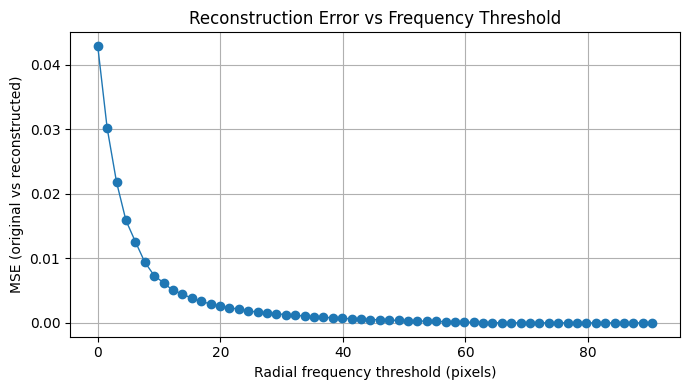

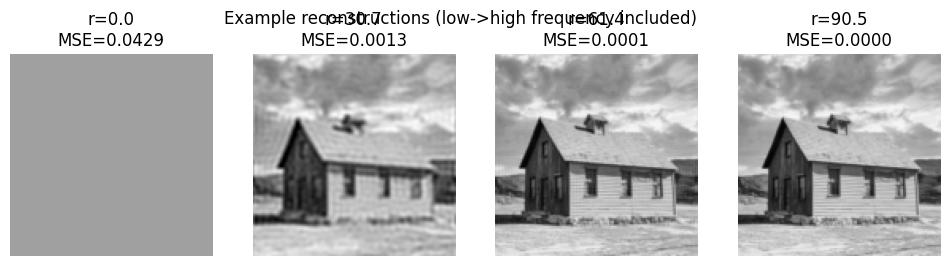

1. When the cutoff radius is very small:

Only smooth parts of the image are kept. Sharp edges and fine details are lost. The image looks blurry, and the error (MSE) is big.

2. When the cutoff radius gets bigger:

More details are kept. The image looks clearer, and the error becomes smaller.

3. When the cutoff radius is very large (almost max):

Almost everything is kept. The image looks almost the same as the original, and the error (MSE) is close to zero.


In [72]:
# DFT/IDFT from scratch, radial thresholding, MSE vs frequency threshold
# Utilities and transform
# function to load image as gray color
def loadImageGray(path: str, maxSize: int = 128) -> np.ndarray:
    """
    Load image as grayscale float64 in range [0,1].
    If image is large, resize (preserves aspect ratio) to keep transforms feasible.
    """
    # open image and convert to gray color
    img = Image.open(path).convert('L')
    # get width and height of image
    W, H = img.size
    # find bigger dimension
    maxDim = max(W, H)
    # check if image is too big
    if maxDim > maxSize:
        # calculate scale factor
        scale = maxSize / maxDim
        # calculate new size
        newSize = (int(W * scale), int(H * scale))
        # resize image
        img = img.resize(newSize, Image.BILINEAR)
        # print resize message
        print(f"Image resized from ({W},{H}) to {newSize} for speed.")
    # convert image to array and normalize to 0-1
    arr = np.asarray(img, dtype=np.float64) / 255.0
    # return the array
    return arr

# function to make DFT matrix
def dftMatrix(N: int, inverse: bool = False) -> np.ndarray:
    """
    Return NxN DFT matrix (complex). inverse=False gives forward DFT matrix:
    W[k,n] = exp(-2j*pi*k*n/N)
    inverse=True gives inverse sign and scaling left to caller.
    """
    # make array from 0 to N-1
    n = np.arange(N)
    # reshape to column vector
    k = n.reshape((N,1))
    # choose sign based on inverse or not
    sign = 1 if inverse else -1
    # calculate DFT matrix using formula
    W = np.exp(sign * 2j * np.pi * k @ n.reshape((1,N)) / N)
    # return the matrix
    return W

# function to do 2D DFT
def dft2D(image: np.ndarray) -> np.ndarray:
    """
    2D DFT computed via matrix multiplication: F = W_M * f * W_N
    where W_M is MxM DFT and W_N is NxN DFT.
    Returns complex array of same shape.
    """
    # get image dimensions
    M, N = image.shape
    # create DFT matrices
    # make DFT matrix for rows
    Wm = dftMatrix(M, inverse=False)    # MxM
    # make DFT matrix for columns
    Wn = dftMatrix(N, inverse=False)    # NxN
    # apply separable transform
    # first along rows: result = Wm @ image
    # multiply matrix with image for rows
    mid = Wm @ image
    # multiply result with column matrix
    F = mid @ Wn
    # return the 2D DFT result
    return F

# function to do 2D inverse DFT
def idft2D(F: np.ndarray) -> np.ndarray:
    """
    2D inverse DFT via matrix multiplication, with scaling 1/(MN).
    """
    # get dimensions of frequency domain array
    M, N = F.shape
    # make inverse DFT matrix for rows
    WmInv = dftMatrix(M, inverse=True)
    # make inverse DFT matrix for columns
    WnInv = dftMatrix(N, inverse=True)
    # multiply inverse matrix with frequency array
    mid = WmInv @ F
    # multiply result with column inverse matrix
    fRec = mid @ WnInv
    # normalization
    # divide by total size for correct scaling
    fRec = fRec / (M * N)
    # result should be complex; return real part (imag should be near-zero)
    # return only real part (imaginary part should be almost zero)
    return fRec.real

# function to move zero frequency to center
def fftshift2D(x: np.ndarray) -> np.ndarray:
    """Shift zero-frequency component to center (2D)"""
    # get array dimensions
    M, N = x.shape
    # shift array to center zero frequency
    return np.roll(np.roll(x, shift=M//2, axis=0), shift=N//2, axis=1)

# function to undo the shift
def ifftshift2D(x: np.ndarray) -> np.ndarray:
    """Inverse shift (undo fftshift)"""
    # get array dimensions
    M, N = x.shape
    # shift array back to original position
    return np.roll(np.roll(x, shift=-(M//2), axis=0), shift=-(N//2), axis=1)

# -------------------------
# Radial mask and MSE loop
# -------------------------

# function to make circular mask
def radialMask(shape: Tuple[int,int], radius: float, center: Tuple[float,float]=None) -> np.ndarray:
    """Return boolean mask with True for frequencies <= radius (center in pixels)."""
    # get shape dimensions
    M, N = shape
    # check if center not given
    if center is None:
        # use middle of image as center
        cy, cx = M/2, N/2
    else:
        # if center given
        # use given center
        cy, cx = center
    # make y coordinates
    y = np.arange(M).reshape(M,1)
    # make x coordinates
    x = np.arange(N).reshape(1,N)
    # calculate distance from center
    dist = np.sqrt((y - cy)**2 + (x - cx)**2)
    # return true where distance is less than radius
    return dist <= radius

# function to calculate error
def computeMse(original: np.ndarray, reconstructed: np.ndarray) -> float:
    # find difference between original and reconstructed
    diff = original - reconstructed
    # return mean squared error
    return np.mean((diff)**2)

# -------------------------
# Main pipeline
# -------------------------

# main function to do reconstruction and plot
def runReconstructionAndPlot(imagePath='a_3_1.png',
                                radii=None,  # optional radii list
                                maxSize=128,  # maximum image size
                                showExamples=True):  # whether to show example images
    # load
    # load image as gray
    img = loadImageGray(imagePath, maxSize=maxSize)
    # get image dimensions
    M, N = img.shape
    # print image size
    print(f"Image shape used: {img.shape}")

    # compute full 2D DFT from scratch
    # do 2D DFT on image
    F = dft2D(img)   # complex
    # shift for visualization / radial masking around center
    # shift zero frequency to center
    FShift = fftshift2D(F)

    # radii to evaluate
    # check if radii not given
    if radii is None:
        # choose radii up to the maximum distance from center
        # calculate maximum radius
        maxRad = math.hypot(M/2, N/2)
        # 60 sample thresholds
        # make 60 radius values
        radii = np.linspace(0, maxRad, 60)

    # list to store MSE values
    mses = []
    # store a few examples for display
    # list to store example reconstructions
    reconstructions = []
    # loop through each radius
    for r in radii:
        # True inside radius
        # make circular mask
        mask = radialMask((M,N), radius=r)
        # keep only frequencies inside mask (low-pass). For "high-pass", invert mask.
        # apply mask to frequency domain
        FMaskedShift = FShift * mask
        # shift back then inverse DFT
        # shift back to original position
        FMasked = ifftshift2D(FMaskedShift)
        # do inverse DFT to get image back
        fRec = idft2D(FMasked)
        # clip to [0,1]
        # make sure values are between 0 and 1
        fRecClipped = np.clip(fRec, 0.0, 1.0)
        # calculate error
        mse = computeMse(img, fRecClipped)
        # add error to list
        mses.append(mse)

        # store a few reconstructions (start, mid, end)
        # store reconstruction example
        reconstructions.append((r, fRecClipped))
    # convert MSE list to array
    mses = np.array(mses)

    # Plot MSE vs radius
    # create new figure
    plt.figure(figsize=(7,4))
    # plot error vs radius
    plt.plot(radii, mses, marker='o', linewidth=1)
    # label x axis
    plt.xlabel('Radial frequency threshold (pixels)')
    # label y axis
    plt.ylabel('MSE (original vs reconstructed)')
    # add title
    plt.title('Reconstruction Error vs Frequency Threshold')
    # add grid
    plt.grid(True)
    # make layout better
    plt.tight_layout()
    # show the plot
    plt.show()

    # Show example reconstructions: small, medium, large radius
    # check if should show examples
    if showExamples:
        # pick 4 example indices
        exampleIdxs = [0, len(radii)//3, 2*len(radii)//3, len(radii)-1]
        # get number of examples
        n = len(exampleIdxs)
        # create figure for examples
        plt.figure(figsize=(3*n,3))
        # loop through examples
        for i, idx in enumerate(exampleIdxs):
            # get radius and reconstruction
            r, rec = reconstructions[idx]
            # create subplot
            plt.subplot(1, n, i+1)
            # show image
            plt.imshow(rec, cmap='gray', vmin=0, vmax=1)
            # add title with radius and error
            plt.title(f'r={r:.1f}\nMSE={mses[idx]:.4f}')
            # hide axes
            plt.axis('off')
        # add main title
        plt.suptitle('Example reconstructions (low->high frequency included)')
        # show the plot
        plt.show()

    # Return raw results for further analysis if desired
    # return dictionary with results
    return {
        # original image
        'image': img,
        # frequency domain
        'F': F,
        # radius values used
        'radii': radii,
        # error values
        'mses': mses,
        # example reconstructions
        'reconstructions': reconstructions
    }

# Replace 'a_3_1.png' with a valid path in your Colab environment.
# run the main function
results = runReconstructionAndPlot('a_3_1.png', maxSize=128)

print("1. When the cutoff radius is very small:\n")
print("Only smooth parts of the image are kept. Sharp edges and fine details are lost. The image looks blurry, and the error (MSE) is big.")
print("\n2. When the cutoff radius gets bigger:\n")
print("More details are kept. The image looks clearer, and the error becomes smaller.")
print("\n3. When the cutoff radius is very large (almost max):\n")
print("Almost everything is kept. The image looks almost the same as the original, and the error (MSE) is close to zero.")

Task 2: Creating a hybrid image in the frequency domain

a. Perform low pass Gaussian filtering in the frequency domain on the given cat
image (a_3_2_1.png). Take the cutoff (standard deviation) at 0.015 times the
width (the width and height of the cat image are both 512).

b. Perform high pass Gaussian filtering on the given dog image (a_3_2_2.png).
Take the cutoff (standard deviation) at 0.015 times the width (the width and
height of the dog image are both 512).

c. Create a hybrid spectrum by combining the filtered spectra of the dog and cat
images (by summing the DFTs coefficients of the filtered images)  

d. Perform IDFT using the hybrid spectrum and show the image obtained after
IDFT.   

e. Is there any effect of the viewing distance on the type of animal (dog or cat)
that you perceive? Explain your observation.

Image shape: (512, 512)
Computing DFTs (this may take a few seconds)...
Using sigma = 0.015 * width = 7.6800 pixels
Computing inverse DFT (IDFT) to obtain hybrid image...


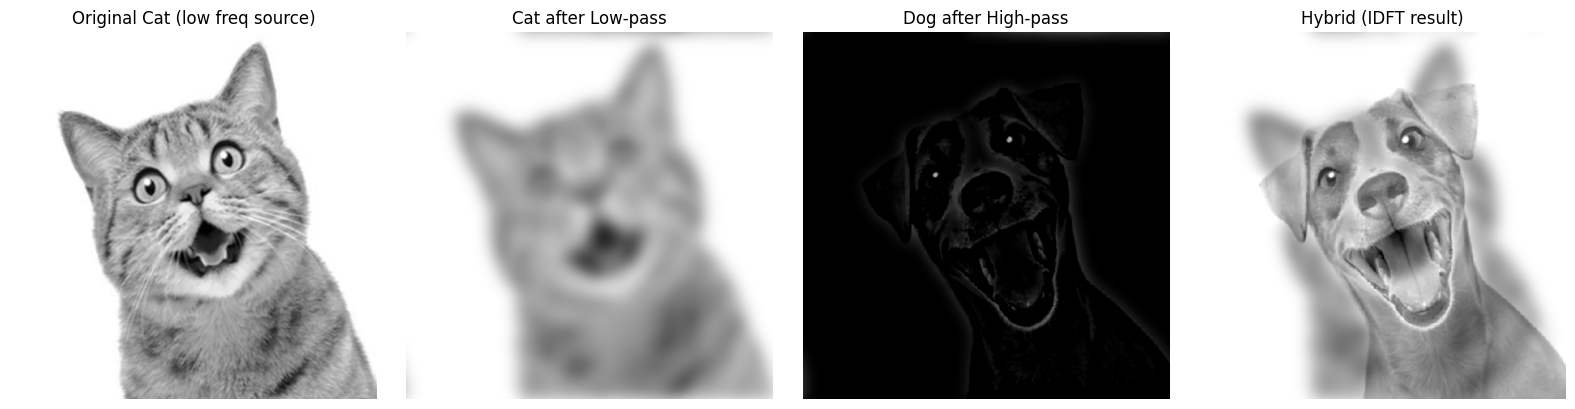

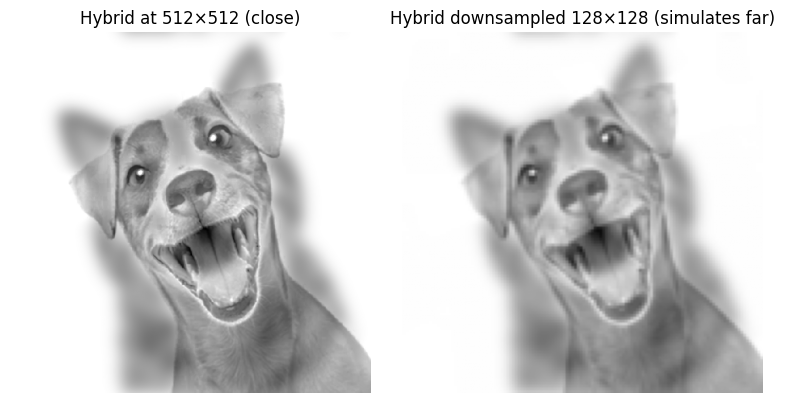


Low-pass (blurred) cat image -> Shows big smooth shapes (low frequencies).


High-pass (sharp edges) dog image -> Shows fine details and edges (high frequencies).


When we look close (original size, 512×512): The dog’s sharp details are clear, so we see the dog.


When we look from far (or smaller size, like 128×128): The small details fade, and the big smooth cat features stay, so we see the cat.



In [73]:

# ColabTask 2 — hybrid image in frequency domain (from-scratch DFT/IDFT)

# ------------------------
# Gaussian masks in frequency domain
# ------------------------
# function to make low pass filter
def gaussianLowpassMask(shape, sigma):
    # get shape dimensions
    M, N = shape
    # find center point
    cy, cx = M/2, N/2
    # make y coordinates
    y = np.arange(M).reshape(M,1)
    # make x coordinates
    x = np.arange(N).reshape(1,N)
    # calculate distance squared from center
    D2 = (y-cy)**2 + (x-cx)**2
    # calculate gaussian filter
    H = np.exp(-D2 / (2 * (sigma**2)))
    # return the filter
    return H

# function to make high pass filter
def gaussianHighpassMask(shape, sigma):
    # high pass is 1 minus low pass
    return 1.0 - gaussianLowpassMask(shape, sigma)

# ------------------------
# Utilities: load and show
# ------------------------
# function to load gray image
def loadGray(path, expectedSize=(512,512)):
    # open image and convert to gray
    img = Image.open(path).convert('L')
    # check if size is wrong
    if img.size != expectedSize:
        # print resize message
        print(f"Resizing {path} from {img.size} -> {expectedSize}")
        # resize image
        img = img.resize(expectedSize, Image.BILINEAR)
    # convert to array and normalize
    arr = np.asarray(img, dtype=np.float64) / 255.0
    # return the array
    return arr

# function to show multiple images
def showImagesGrid(imgs, titles, cmap='gray', figsize=(12,6)):
    # get number of images
    n = len(imgs)
    # create figure
    plt.figure(figsize=figsize)
    # loop through images
    for i in range(n):
        # create subplot
        plt.subplot(1,n,i+1)
        # show image
        plt.imshow(imgs[i], cmap=cmap, vmin=0, vmax=1)
        # add title
        plt.title(titles[i])
        # hide axes
        plt.axis('off')
    # make layout better
    plt.tight_layout()
    # show the plot
    plt.show()

# ------------------------
# Main pipeline for Task 2
# ------------------------
# main function for hybrid image
def hybridFrequencyDomain(catPath='a_3_2_1.png', dogPath='a_3_2_2.png'):
    # 1) Load images (grayscale)
    # load cat image
    cat = loadGray(catPath, expectedSize=(512,512))
    # load dog image
    dog = loadGray(dogPath, expectedSize=(512,512))
    # get image shape
    shape = cat.shape
    # print shape
    print("Image shape:", shape)

    # 2) Compute DFTs from scratch
    # print message
    print("Computing DFTs (this may take a few seconds)...")
    # do DFT on cat
    FCat = dft2D(cat)
    # do DFT on dog
    FDog = dft2D(dog)

    # 3) Shift to center for filtering
    # shift cat DFT to center
    FCatShift = fftshift2D(FCat)
    # shift dog DFT to center
    FDogShift = fftshift2D(FDog)

    # 4) Build Gaussian masks
    # 512
    # get width
    width = shape[1]
    # calculate sigma
    sigma = 0.015 * width
    # print sigma value
    print(f"Using sigma = 0.015 * width = {sigma:.4f} pixels")
    # for cat (low-pass)
    # make low pass filter
    HLow = gaussianLowpassMask(shape, sigma=sigma)
    # for dog (high-pass)
    # make high pass filter
    HHigh = gaussianHighpassMask(shape, sigma=sigma)

    # 5) Apply filters in frequency domain
    # apply low pass filter to cat
    FCatFilteredShift = FCatShift * HLow
    # apply high pass filter to dog
    FDogFilteredShift = FDogShift * HHigh

    # 6) Hybrid spectrum: sum filtered spectra (shifted)
    # add filtered images together
    hybridShift = FCatFilteredShift + FDogFilteredShift

    # 7) Inverse shift and IDFT (from scratch)
    # shift back to original position
    hybrid = ifftshift2D(hybridShift)
    # print message
    print("Computing inverse DFT (IDFT) to obtain hybrid image...")
    # do inverse DFT
    hybridImg = idft2D(hybrid)
    # make sure values are between 0 and 1
    hybridImg = np.clip(hybridImg, 0.0, 1.0)

    # 8) For visualization: also show low-pass cat, high-pass dog reconstructions
    # reconstruct low pass cat
    catRec = idft2D(ifftshift2D(FCatFilteredShift))
    # reconstruct high pass dog
    dogRec = idft2D(ifftshift2D(FDogFilteredShift))
    # clip cat reconstruction
    catRec = np.clip(catRec.real, 0.0, 1.0)
    # clip dog reconstruction
    dogRec = np.clip(dogRec.real, 0.0, 1.0)

    # 9) Display results
    # show all images
    showImagesGrid(
        # list of images
        [cat, catRec, dogRec, hybridImg],
        # titles
        ["Original Cat (low freq source)", "Cat after Low-pass", "Dog after High-pass", "Hybrid (IDFT result)"],
        # figure size
        figsize=(16,4)
    )

    # 10) Simulate viewing distance effect by downsampling hybrid (small size simulates far view)
    # make small version
    small = np.array(Image.fromarray((hybridImg*255).astype(np.uint8)).resize((128,128), Image.BILINEAR)) / 255.0
    # 512
    # keep large version
    large = hybridImg
    # show both sizes
    showImagesGrid([large, small], ["Hybrid at 512×512 (close)", "Hybrid downsampled 128×128 (simulates far)"], figsize=(8,4))

    # return results dictionary
    return {
        # original cat
        'cat': cat,
        # original dog
        'dog': dog,
        # cat frequency domain
        'FCat': FCat,
        # dog frequency domain
        'FDog': FDog,
        # low pass filter
        'HLow': HLow,
        # high pass filter
        'HHigh': HHigh,
        # final hybrid image
        'hybridImg': hybridImg,
        # cat low pass reconstruction
        'catLpRec': catRec,
        # dog high pass reconstruction
        'dogHpRec': dogRec
    }

# ------------------------
# Run Task 2
# ------------------------
# run hybrid image function
results = hybridFrequencyDomain('a_3_2_1.png','a_3_2_2.png')


# task 2: e
print("\nLow-pass (blurred) cat image -> Shows big smooth shapes (low frequencies).\n")
print("\nHigh-pass (sharp edges) dog image -> Shows fine details and edges (high frequencies).\n")
print("\nWhen we look close (original size, 512×512): The dog’s sharp details are clear, so we see the dog.\n")
print("\nWhen we look from far (or smaller size, like 128×128): The small details fade, and the big smooth cat features stay, so we see the cat.\n")

Task 3: Watermarking in the frequency domain

a. Perform the DFT of the given base image (a_3_1.png) and display the
magnitude and phase components of the centered DFT.   

b. Embed a small watermark image (a_3_watermark.png) in the mid-band of
frequencies by replacing the values of the magnitude spectrum with the pixels
of the watermark image. Your embedding operation must ensure that the
even symmetry of the magnitude spectrum is preserved. NOTE: Scale the
watermark image amplitude to the range of [0.0, 50.0] before embedding, so
that it is visible in the magnitude plot.

c. Show the modified magnitude spectrum.   

d. Using the modified magnitude spectrum and the original phase spectrum
perform IDFT to reconstruct the image.   

e. Submit the reconstructed image as a .png file.   

f.
What would happen if you would have embedded the watermark at very low
or very high frequency regions of the magnitude spectrum? Explain.

Base image shape: (512, 512)
Computing 2D DFT (from-scratch). This may take a few seconds...


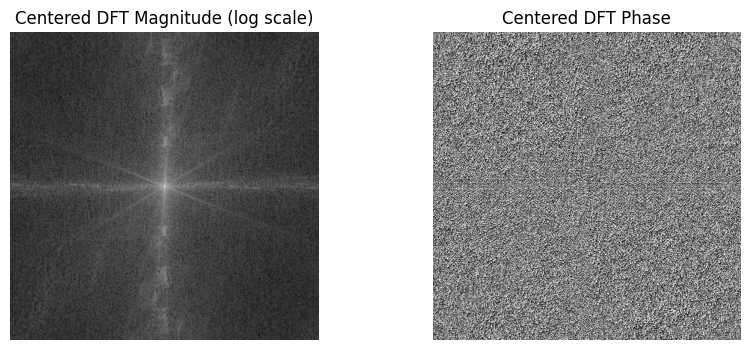

Watermark shape used: (64, 64)


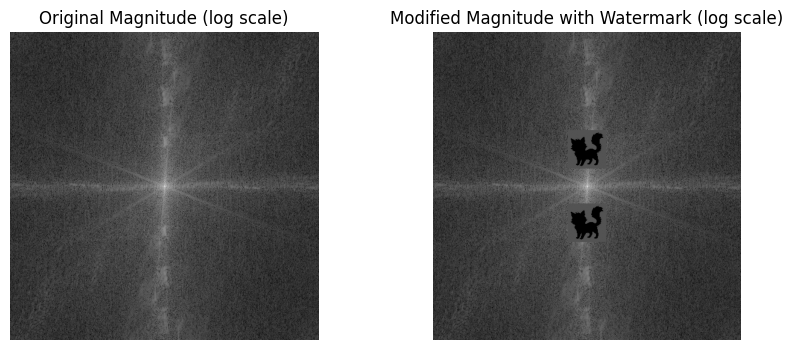

Computing inverse DFT of modified spectrum...


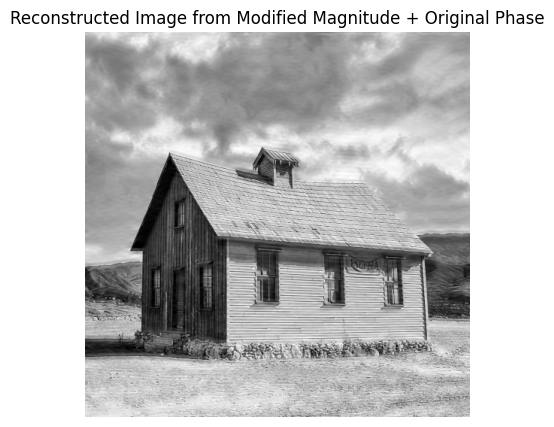


Explanation (part f):
If we hide data in very low-frequency areas (near DC): 
It changes the overall look of the image (brightness/shape). 
This is easy to notice, even from far away.

If we hide data in very high-frequency areas: 
It changes edges and fine textures. 
This is harder to see from normal distance, 
but can disappear with smoothing/compression, 
and may show tiny artifacts if you look closely.

If we hide data in mid-frequency areas (what we did): 
It’s a balance. 
Not as visible as low-frequency changes, 
but stronger and easier to keep than very-high-frequency changes.



In [74]:
# Task 3: Watermarking in frequency domain (DFT/IDFT from scratch)

# import os for file operations
import os

# function to show single image
def showImage(img, title='', cmap='gray'):
    # create figure
    plt.figure(figsize=(5,5))
    # show image
    plt.imshow(img, cmap=cmap)
    # add title
    plt.title(title)
    # hide axes
    plt.axis('off')
    # show the plot
    plt.show()

# ---------- Main ----------
# path to base image
basePath = 'a_3_1.png'
# path to watermark image
wmPath = 'a_3_watermark.png'

# check if files exist
if not os.path.exists(basePath) or not os.path.exists(wmPath):
    # error if files missing
    raise FileNotFoundError("Please upload 'a_3_1.png' and 'a_3_watermark.png' to the working directory and re-run.")

# (a) Compute centered DFT, display magnitude & phase
# load base image
base = loadGray(basePath)
# get image dimensions
M, N = base.shape
# print shape
print("Base image shape:", base.shape)

# print message
print("Computing 2D DFT (from-scratch). This may take a few seconds...")
# do 2D DFT
F = dft2D(base)
# shift to center
FShift = fftshift2D(F)

# calculate magnitude
magnitude = np.abs(FShift)
# calculate phase
phase = np.angle(FShift)

# create figure
plt.figure(figsize=(10,4))
# first subplot
plt.subplot(1,2,1)
# show magnitude in log scale
plt.imshow(np.log1p(magnitude), cmap='gray')
# add title
plt.title('Centered DFT Magnitude (log scale)')
# hide axes
plt.axis('off')
# second subplot
plt.subplot(1,2,2)
# show phase
plt.imshow(phase, cmap='gray')
# add title
plt.title('Centered DFT Phase')
# hide axes
plt.axis('off')
# show the plot
plt.show()

# (b) Embed watermark in mid-band preserving magnitude even symmetry
# open watermark image
wm = Image.open(wmPath).convert('L')
# convert to array and normalize
wmArr = np.asarray(wm, dtype=np.float64) / 255.0

# Resize watermark if too big (safe default)
# calculate maximum size
maxEmbedSize = min(128, M//4)
# check if too big
if wmArr.shape[0] > maxEmbedSize or wmArr.shape[1] > maxEmbedSize:
    # resize watermark
    wm = wm.resize((maxEmbedSize, maxEmbedSize), Image.BILINEAR)
    # convert again
    wmArr = np.asarray(wm, dtype=np.float64) / 255.0

# get watermark dimensions
wh, ww = wmArr.shape
# print watermark size
print("Watermark shape used:", (wh, ww))

# Scale watermark to [0, 50]
# subtract minimum value
wmScaled = wmArr - wmArr.min()
# check if max is positive
if wmScaled.max() > 0:
    # normalize to 0-1
    wmScaled = wmScaled / wmScaled.max()
# scale to 0-50
wmScaled = wmScaled * 50.0

# Choose embedding location in mid-band (centered horizontally, offset radially)
# find center
cy, cx = M//2, N//2
# ~12% of dimension -> mid-band
# calculate offset
offsetR = int(min(M, N) * 0.12)
# calculate start row
i0 = cy - wh//2 - offsetR
# calculate start column
j0 = cx - ww//2
# make sure i0 is valid
i0 = max(0, min(M-wh, i0))
# make sure j0 is valid
j0 = max(0, min(N-ww, j0))

# copy magnitude
magMod = magnitude.copy()

# Place watermark block and symmetric block to preserve even symmetry
# place watermark
magMod[i0:i0+wh, j0:j0+ww] = wmScaled
# calculate symmetric row
si0 = M - (i0 + wh)
# calculate symmetric column
sj0 = N - (j0 + ww)
# place symmetric watermark
magMod[si0:si0+wh, sj0:sj0+ww] = wmScaled

# (c) Show modified magnitude
# create figure
plt.figure(figsize=(10,4))
# first subplot
plt.subplot(1,2,1)
# show original magnitude
plt.imshow(np.log1p(magnitude), cmap='gray')
# add title
plt.title('Original Magnitude (log scale)')
# hide axes
plt.axis('off')
# second subplot
plt.subplot(1,2,2)
# show modified magnitude
plt.imshow(np.log1p(magMod), cmap='gray')
# add title
plt.title('Modified Magnitude with Watermark (log scale)')
# hide axes
plt.axis('off')
# show the plot
plt.show()

# (d) Reconstruct using modified magnitude + original phase
# combine modified magnitude with original phase
FModShift = magMod * np.exp(1j * phase)
# shift back to original position
FMod = ifftshift2D(FModShift)

# print message
print("Computing inverse DFT of modified spectrum...")
# do inverse DFT
recon = idft2D(FMod)
# clip values to 0-1
reconClipped = np.clip(recon, 0.0, 1.0)

# show result
showImage(reconClipped, 'Reconstructed Image from Modified Magnitude + Original Phase')
# save image
Image.fromarray((reconClipped*255).astype(np.uint8)).save("25AI60R28_Task3e_output.png")

# (f) Explanation printed:
print("""
Explanation (part f):
If we hide data in very low-frequency areas (near DC):
It changes the overall look of the image (brightness/shape).
This is easy to notice, even from far away.

If we hide data in very high-frequency areas:
It changes edges and fine textures.
This is harder to see from normal distance,
but can disappear with smoothing/compression,
and may show tiny artifacts if you look closely.

If we hide data in mid-frequency areas (what we did):
It’s a balance.
Not as visible as low-frequency changes,
but stronger and easier to keep than very-high-frequency changes.
""")
